# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMeasuredVsPredicted, plotScoresLoadings, clusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, BackgroundSeqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
pd.set_option('display.max_colwidth', 1000)

ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y")

header = ABC.columns
treatments = ABC.columns[2:12]

data = ABC.iloc[:, 2:12].T
protnames = ABC.iloc[:, 1]
seqs = ABC.iloc[:, 0]

In [3]:
# ABC

### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

In [5]:
ncl = 5
pYTS = "Y"
GMMweight = 0.5
covariance_type = "diag" 
max_n_iter = 20

In [6]:
pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

MSC = MassSpecClustering(seqs, protnames, ncl, distance_method="PAM250").fit(data, Y_cv)
centers = MSC.transform(data)

In [7]:
MSC.transform(data)

,0,1,2,3,4
0,0.774000,0.518599,0.915019,0.802935,1.038080
1,0.371917,0.235970,0.427075,0.416736,0.375038
2,0.117141,0.136964,0.318037,0.306474,0.265960
3,-0.501945,-0.394932,-0.436435,-0.403141,-0.504095
4,-0.010817,0.038149,0.082736,0.182842,0.024523
5,-0.085403,-0.074052,-0.088127,-0.007808,-0.168646
6,-0.054261,-0.028205,0.004794,0.025756,-0.129543
7,-0.262048,-0.203708,-0.356373,-0.465425,-0.376932
8,0.072410,0.145583,-0.081355,-0.128430,0.002031
9,-0.420995,-0.374369,-0.483175,-0.729940,-0.526417


In [8]:
members = MSC.clustermembers(ABC.T)

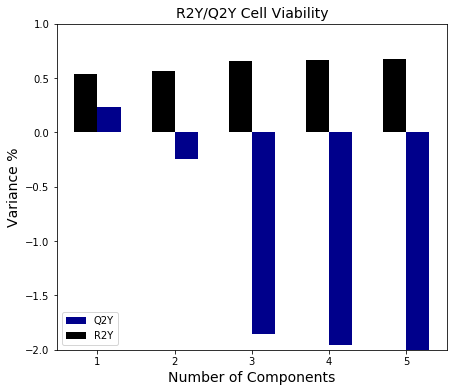

In [9]:
Q2Y = Q2Y_across_components(centers, Y_cv, ncl+1)
R2Y = R2Y_across_components(centers, Y_cv, ncl+1)

range_ = np.linspace(1, ncl, ncl)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability", fontsize=14)
plt.ylabel("Variance %", fontsize=14)
plt.xlabel("Number of Components", fontsize=14)
plt.ylim(-2,1)
plt.legend(loc=3)

In [10]:
# CVresults_max, CVresults_min, best_params = MSclusPLSR_tuning(data, seqs, protnames, Y_cv)
# CVresults_min.nlargest(30, "mean_test_scores")

In [11]:
# ncl_GMMweight_ncomp = CVresults_min.sort_values(by="Ranking")
# create_download_link(ncl_GMMweight_ncomp, "ncl_GMMweight_ncomp")

Hyperparameter Tuning with Binomial Clustering:

In [12]:
pd.read_csv('./msresist/data/09252019-HyperparameterTuning_Binomial_ncl_GMMweight_ncomp.csv').iloc[:30, :11].iloc[:, 1:]

,Ranking,#Clusters,GMMweights,#ComponentsPLSR,mean_test_scores,mean_train_scores
0,1,2,2.5,2,-11.394670,-7.256597
1,2,2,5.0,2,-11.852214,-7.301871
2,3,2,0.5,2,-11.875249,-7.546528
3,4,4,2.5,1,-12.983479,-7.450285
4,5,5,2.5,1,-13.149582,-7.374562
5,6,5,0.5,1,-13.354861,-7.367209
6,7,6,0.5,1,-13.356816,-7.313067
7,8,7,2.5,1,-13.389536,-7.317714
8,9,3,2.5,1,-13.492450,-7.433888
9,10,4,5.0,1,-13.813688,-7.415974


Hyperparameter Tuning with PAM250 clustering

In [13]:
pd.read_csv('./msresist/data/19102019-HyperparameterTuning_PAM250_ncl_GMMweight_ncomp.csv').iloc[:30, :11].iloc[:, 1:]

,Ranking,#Clusters,GMMweights,#ComponentsPLSR,mean_test_scores,mean_train_scores
0,1,2,2.5,2,-11.493039,-7.264197
1,2,2,0.5,2,-12.030554,-7.396359
2,3,3,5.0,2,-13.226831,-7.094470
3,4,4,5.0,2,-13.428525,-6.479736
4,5,6,5.0,1,-13.526919,-8.135111
5,6,6,0.5,1,-13.556408,-8.123810
6,7,5,2.5,1,-13.688699,-8.109123
7,8,4,2.5,1,-13.798894,-8.155120
8,9,4,2.5,2,-13.808207,-6.845446
9,10,7,5.0,3,-13.814511,-4.220784


In [14]:
ncl, GMMweight, ncomp = 2, 2.5, 2

In [19]:
mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(seqs, protnames, ncl, GMMweight=GMMweight, distance_method="PAM250")), ('plsr', PLSRegression(ncomp))])

In [20]:
X_scores, Y_scores = mixedCl_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = mixedCl_plsr.named_steps.plsr.x_loadings_[:, 0], mixedCl_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = mixedCl_plsr.named_steps.plsr.y_loadings_[:, 0], mixedCl_plsr.named_steps.plsr.y_loadings_[:, 1]

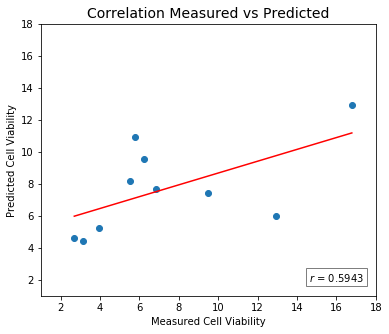

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)
plt.title("Correlation Measured vs Predicted", fontsize=14);

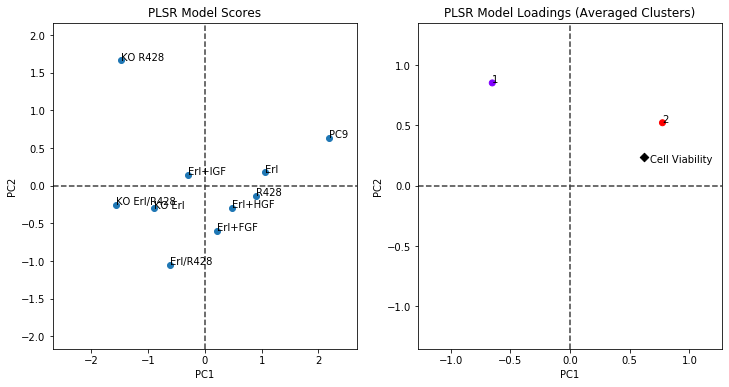

In [22]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([(-1*max(PC1_scores))-0.5, max(PC1_scores)+0.5])
axs[0].set_ylim([(-1*max(PC2_scores))-0.5, max(PC2_scores)+0.5])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].annotate("Cell Viability", (PC1_yload+0.05, PC2_yload-0.05))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([(-1*max(PC1_xload))-0.5, max(PC1_xload)+0.5])
axs[1].set_ylim([(-1*max(PC2_xload))-0.5, max(PC2_xload)+0.5]);

In [23]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,pos_Cluster_1,Cluster_2,seqs_Cluster_2,pos_Cluster_2
0,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,Y12-p,Heat shock 70 kDa protein 1A,AAAIAyGLDRT,Y183-p
1,Pyruvate kinase PKM,AEAAIyHLQLF,Y390-p,DNA replication licensing factor MCM7,AANPAyGRYNP,Y492-p
2,Envoplakin,AEDAVyELQSK,Y1352-p,Coactosin-like protein,ACRAAyNLVRD,Y14-p
3,Ras and Rab interactor 1,AQDPLyDVPNA,Y36-p,Kinesin light chain 2,AEEVEyYYRRA,Y345-p
4,Receptor tyrosine-protein kinase erbB-3,ASEQGyEEMRA,Y1289-p,Receptor tyrosine-protein kinase erbB-2,AENPEyLGLDV,Y1248-p
5,Homeodomain-interacting protein kinase 2,AVCSTyLQSRY,Y361-p,Protein-glutamine gamma-glutamyltransferase 2,AERDLyLENPE,Y583-p
6,Cysteine and glycine-rich protein 1,CQKtVyFAEEV,Y18-p,ATPase WRNIP1,AGEEHyNCISA,Y500-p
7,Ephrin type-B receptor 4,DKHGQyLIGHG,Y581-p,Transgelin-2,AGMTGyGMPRQ,Y192-p
8,Kin of IRRE-like protein 1,DPTNGyYNVRA,Y605-p,Protein tweety homolog 3,AHDSLyRVHMP,Y439-p
9,Ephrin type-B receptor 3,EKLQQyIAPGM,Y600-p,Aldo-keto reductase family 1 member B1,AIDVGyRHIDC,Y40-p


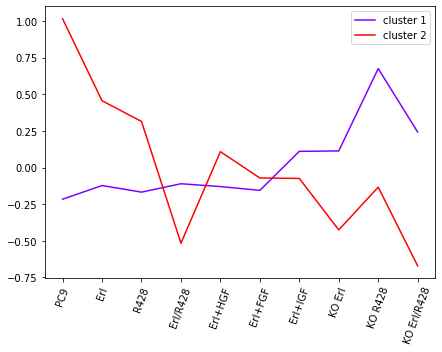

In [24]:
fig = plt.figure(figsize=(7,5))

centers = mixedCl_plsr.named_steps.mixedCl.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);